# Building a multi-language text classifier using Fastai

### Applying transfer learning with Fastai and BERT using HuggingFace 🤗 Transformers.

This notebook is based on this [Medium article](https://medium.com/p/fastai-with-transformers-bert-roberta-xlnet-xlm-distilbert-4f41ee18ecb2?source=email-29c8f5cf1dc4--writer.postDistributed&sk=119c3e5d748b2827af3ea863faae6376).

#### Integrating transformers with fastai for multiclass classification

This notebook illustrates how to build a multi-language text classifier using BERT and Fast.ai using [HuggingFace Transformers](https://github.com/huggingface/transformers).

[HuggingFace Transformers](https://github.com/huggingface/transformers) (formerly known as pytorch-transformers and pytorch-pretrained-bert) provides state-of-the-art general-purpose architectures (BERT, GPT-2, RoBERTa, XLM, DistilBert, XLNet, CTRL...) for Natural Language Understanding (NLU) and Natural Language Generation (NLG) with over 32+ pretrained models in 100+ languages and deep interoperability between TensorFlow 2.0 and PyTorch. Using HuggingFace Transformers is the easieast eay to load BERT into our Fast.ai learning model. 

### Libraries Installation
Before starting the implementation, you will need to install the ``fastai`` and ``transformers`` libraries. To do so, just follow the instructions [here](https://github.com/fastai/fastai/blob/master/README.md#installation) and [here](https://github.com/huggingface/transformers#installation).

If you have ``fastai`` library already installed, you just have to install ``transformers`` with :

In [ ]:
%%bash
pip install -q transformers

## Multilingual BERT

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pathlib import Path 

import os

import torch
import torch.optim as optim

import random 

# fastai
from fastai import *
from fastai.text import *
from fastai.callbacks import *

# transformers
from transformers import PreTrainedModel, PreTrainedTokenizer, PretrainedConfig
from transformers import BertForSequenceClassification, BertTokenizer, BertConfig

The current versions of the fastai and transformers libraries are respectively 1.0.60 and 2.8.0.

In [4]:
import fastai
import transformers
print('fastai version :', fastai.__version__)
print('transformers version :', transformers.__version__)

fastai version : 1.0.60
transformers version : 2.8.0


## Text classification task
The chosen task is a multi-class text classification on [PubMed 200k RCT dataset](https://github.com/Franck-Dernoncourt/pubmed-rct/): a large dataset for sequential sentence classification.

The PubMed 200k RCT dataset is described in *Franck Dernoncourt, Ji Young Lee. [PubMed 200k RCT: a Dataset for Sequential Sentence Classification in Medical Abstracts](https://arxiv.org/abs/1710.06071). International Joint Conference on Natural Language Processing (IJCNLP). 2017.*.

> PubMed 200k RCT is new dataset based on PubMed for sequential sentence classification. The dataset consists of approximately 200,000 abstracts of randomized controlled trials, totaling 2.3 million sentences. Each sentence of each abstract is labeled with their role in the abstract using one of the following classes: background, objective, method, result, or conclusion. The purpose of releasing this dataset is twofold. First, the majority of datasets for sequential short-text classification (i.e., classification of short texts that appear in sequences) are small: we hope that releasing a new large dataset will help develop more accurate algorithms for this task. Second, from an application perspective, researchers need better tools to efficiently skim through the literature. Automatically classifying each sentence in an abstract would help researchers read abstracts more efficiently, especially in fields where abstracts may be long, such as the medical field.


For each sentence, the model has to predict a label for the sentence. We evaluate the outputs of the model on classification accuracy. The avaiable labels are:
* BACKGROUNDS
* OBJECTIVE
* METHODS
* RESULTS
* CONCLUSIONS

The data is loaded into a ``DataFrame`` using ``pandas``.

In [5]:
DATA_ROOT = Path("/home/arianpasquali/datasets/pubmed-rct/PubMed_200k_RCT")
train = pd.read_csv(DATA_ROOT / 'train.txt', sep="\t", skiprows=[0], names=["concept","text"])
test = pd.read_csv(DATA_ROOT / 'test.txt', sep="\t", skiprows=[0], names=["concept","text"])

train.dropna(axis=0, inplace=True)
test.dropna(axis=0, inplace=True)

print(train.shape,test.shape)
train.head()

(2211861, 2) (29493, 2)


,concept,text
0,BACKGROUND,The emergence of HIV as a chronic condition me...
1,BACKGROUND,This paper describes the design and evaluation...
2,METHODS,This study is designed as a randomised control...
3,METHODS,The intervention group will participate in the...
4,METHODS,The program is based on self-efficacy theory a...


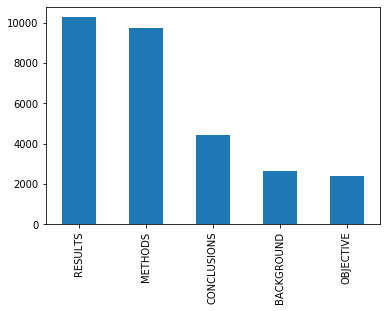

In [11]:
test["concept"].value_counts().plot(kind="bar")

In [6]:
categories = test["concept"].unique().tolist(); categories

['BACKGROUND', 'METHODS', 'RESULTS', 'CONCLUSIONS', 'OBJECTIVE']

## Main transformers classes
In ``transformers``, each model architecture is associated with 3 main types of classes:
* A **model class** to load/store a particular pre-train model.
* A **tokenizer class** to pre-process the data and make it compatible with a particular model.
* A **configuration class** to load/store the configuration of a particular model.

For example, if you want to use the Bert architecture for text classification, you would use [``BertForSequenceClassification``](https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification) for the **model class**, [``BertTokenizer``](https://huggingface.co/transformers/model_doc/bert.html#berttokenizer) for the **tokenizer class** and [``BertConfig``](https://huggingface.co/transformers/model_doc/bert.html#bertconfig) for the **configuration class**. 

In [14]:
MODEL_CLASSES = {
    'bert': (BertForSequenceClassification, BertTokenizer, BertConfig),
}

Print the available pre-trained models for **BERT**.

In [12]:
BertForSequenceClassification.pretrained_model_archive_map.keys()

dict_keys(['bert-base-uncased', 'bert-large-uncased', 'bert-base-cased', 'bert-large-cased', 'bert-base-multilingual-uncased', 'bert-base-multilingual-cased', 'bert-base-chinese', 'bert-base-german-cased', 'bert-large-uncased-whole-word-masking', 'bert-large-cased-whole-word-masking', 'bert-large-uncased-whole-word-masking-finetuned-squad', 'bert-large-cased-whole-word-masking-finetuned-squad', 'bert-base-cased-finetuned-mrpc', 'bert-base-german-dbmdz-cased', 'bert-base-german-dbmdz-uncased', 'bert-base-japanese', 'bert-base-japanese-whole-word-masking', 'bert-base-japanese-char', 'bert-base-japanese-char-whole-word-masking', 'bert-base-finnish-cased-v1', 'bert-base-finnish-uncased-v1', 'bert-base-dutch-cased'])

You will see later, that those classes share a common class method ``from_pretrained(pretrained_model_name, ...)``. In our case, the parameter ``pretrained_model_name`` is a string with the shortcut name of a pre-trained model/tokenizer/configuration to load, e.g ``'bert-base-uncased'``. We can find all the shortcut names in the transformers documentation [here](https://huggingface.co/transformers/pretrained_models.html#pretrained-models).

In [ ]:
# Parameters
seed = 42
use_fp16 = False
bs = 16

model_type = 'bert'
pretrained_model_name='bert-base-multilingual-uncased'

In [18]:
model_class, tokenizer_class, config_class = MODEL_CLASSES[model_type]

### Util function

Function to set the seed for generating random numbers.

In [20]:
def seed_all(seed_value):
    random.seed(seed_value) # Python
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False
        
seed_all(seed)        

## Data pre-processing

To match pre-training, we have to format the model input sequence in a specific format.
To do so, you have to first **tokenize** and then **numericalize** the texts correctly.
The difficulty here is that each pre-trained model, that we will fine-tune, requires exactly the same specific pre-process - **tokenization** & **numericalization** - than the pre-process used during the pre-train part.
Fortunately, the **tokenizer class** from ``transformers`` provides the correct pre-process tools that correspond to each pre-trained model.

In the ``fastai`` library, data pre-processing is done automatically during the creation of the ``DataBunch``. 
As you will see in the ``DataBunch`` implementation, the **tokenizer** and **numericalizer** are passed in the processor argument under the following format :

``processor = [TokenizeProcessor(tokenizer=tokenizer,...), NumericalizeProcessor(vocab=vocab,...)]``

Let's first analyse how we can integrate the ``transformers`` **tokenizer** within the ``TokenizeProcessor`` function.

### Custom Tokenizer
This part can be a little bit confusing because a lot of classes are wrapped in each other and with similar names.
To resume, if we look attentively at the ``fastai`` implementation, we notice that :
1. The [``TokenizeProcessor`` object](https://docs.fast.ai/text.data.html#TokenizeProcessor) takes as ``tokenizer`` argument a ``Tokenizer`` object.
2. The [``Tokenizer`` object](https://docs.fast.ai/text.transform.html#Tokenizer) takes as ``tok_func`` argument a ``BaseTokenizer`` object.
3. The [``BaseTokenizer`` object](https://docs.fast.ai/text.transform.html#BaseTokenizer) implement the function ``tokenizer(t:str) → List[str]`` that take a text ``t`` and returns the list of its tokens.

Therefore, we can simply create a new class ``TransformersBaseTokenizer`` that inherits from ``BaseTokenizer`` and overwrite a new ``tokenizer`` function.


In [21]:
class TransformersBaseTokenizer(BaseTokenizer):
    """Wrapper around PreTrainedTokenizer to be compatible with fast.ai"""
    def __init__(self, pretrained_tokenizer: PreTrainedTokenizer, model_type = 'bert', **kwargs):
        self._pretrained_tokenizer = pretrained_tokenizer
        self.max_seq_len = pretrained_tokenizer.max_len
        self.model_type = model_type

    def __call__(self, *args, **kwargs): 
        return self

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length and add the spesial tokens"""
        CLS = self._pretrained_tokenizer.cls_token
        SEP = self._pretrained_tokenizer.sep_token
        if self.model_type in ['roberta']:
            tokens = self._pretrained_tokenizer.tokenize(t, add_prefix_space=True)[:self.max_seq_len - 2]
            tokens = [CLS] + tokens + [SEP]
        else:
            tokens = self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2]
            if self.model_type in ['xlnet']:
                tokens = tokens + [SEP] +  [CLS]
            else:
                tokens = [CLS] + tokens + [SEP]
        return tokens

In [22]:
transformer_tokenizer = tokenizer_class.from_pretrained(pretrained_model_name)
transformer_base_tokenizer = TransformersBaseTokenizer(pretrained_tokenizer = transformer_tokenizer, model_type = model_type)
fastai_tokenizer = Tokenizer(tok_func = transformer_base_tokenizer, pre_rules=[], post_rules=[])

In this implementation, be carefull about 3 things :
1. As we are not using RNN, we have to limit the sequence length to the model input size.
2. Most of the models require special tokens placed at the beginning and end of the sequences.
3. Some models like RoBERTa require a space to start the input string. For those models, the encoding methods should be called with ``add_prefix_space`` set to ``True``.

Below, you can find the resume of each pre-process requirement for the 5 model types used in this tutorial. You can also find this information on the [HuggingFace documentation](https://huggingface.co/transformers/) in each model section.

    bert:       [CLS] + tokens + [SEP] + padding

    roberta:    [CLS] + prefix_space + tokens + [SEP] + padding
    
    distilbert: [CLS] + tokens + [SEP] + padding

    xlm:        [CLS] + tokens + [SEP] + padding

    xlnet:      padding + tokens + [SEP] + [CLS]
    
It is worth noting that we don't add padding in this part of the implementation. 
As we will see later, ``fastai`` manage it automatically during the creation of the ``DataBunch``.

### Custom Numericalizer

In ``fastai``, [``NumericalizeProcessor``  object](https://docs.fast.ai/text.data.html#NumericalizeProcessor) takes as ``vocab`` argument a [``Vocab`` object](https://docs.fast.ai/text.transform.html#Vocab). 
From this analyse, we suggest two ways to adapt the fastai numericalizer:
1. You can, like decribed in the [Dev Sharma's article](https://medium.com/analytics-vidhya/using-roberta-with-fastai-for-nlp-7ed3fed21f6c) (Section *1. Setting Up the Tokenizer*), retreive the list of tokens and create a ``Vocab`` object.
2. Create a new class ``TransformersVocab`` that inherits from ``Vocab`` and overwrite ``numericalize`` and ``textify`` functions.

Even if the first solution seems to be simpler, ``Transformers`` does not provide, for all models, a straightforward way to retreive his list of tokens. 
Therefore, I implemented the second solution, which runs for each model type.
It consists of using the functions ``convert_tokens_to_ids`` and ``convert_ids_to_tokens`` in respectively ``numericalize`` and ``textify``.

In [23]:
class TransformersVocab(Vocab):
    def __init__(self, tokenizer: PreTrainedTokenizer):
        super(TransformersVocab, self).__init__(itos = [])
        self.tokenizer = tokenizer
    
    def numericalize(self, t:Collection[str]) -> List[int]:
        "Convert a list of tokens `t` to their ids."
        return self.tokenizer.convert_tokens_to_ids(t)
        #return self.tokenizer.encode(t)

    def textify(self, nums:Collection[int], sep=' ') -> List[str]:
        "Convert a list of `nums` to their tokens."
        nums = np.array(nums).tolist()
        return sep.join(self.tokenizer.convert_ids_to_tokens(nums)) if sep is not None else self.tokenizer.convert_ids_to_tokens(nums)
    
    def __getstate__(self):
        return {'itos':self.itos, 'tokenizer':self.tokenizer}

    def __setstate__(self, state:dict):
        self.itos = state['itos']
        self.tokenizer = state['tokenizer']
        self.stoi = collections.defaultdict(int,{v:k for k,v in enumerate(self.itos)})

### Custom processor
Now that we have our custom **tokenizer** and **numericalizer**, we can create the custom **processor**. Notice we are passing the ``include_bos = False`` and ``include_eos = False`` options. This is because ``fastai`` adds its own special tokens by default which interferes with the ``[CLS]`` and ``[SEP]`` tokens added by our custom tokenizer.

In [24]:
transformer_vocab =  TransformersVocab(tokenizer = transformer_tokenizer)
numericalize_processor = NumericalizeProcessor(vocab=transformer_vocab)

tokenize_processor = TokenizeProcessor(tokenizer=fastai_tokenizer, include_bos=False, include_eos=False)

transformer_processor = [tokenize_processor, numericalize_processor]

## Setting up the Databunch
For the DataBunch creation, you have to pay attention to set the processor argument to our new custom processor ``transformer_processor`` and manage correctly the padding.

As mentioned in the HuggingFace documentation, BERT, RoBERTa, XLM and DistilBERT are models with absolute position embeddings, so it's usually advised to pad the inputs on the right rather than the left. Regarding XLNET, it is a model with relative position embeddings, therefore, you can either pad the inputs on the right or on the left.

In [25]:
pad_first = bool(model_type in ['xlnet'])
pad_idx = transformer_tokenizer.pad_token_id

In [27]:
tokens = transformer_tokenizer.tokenize('Salut c est moi, Hello it s me, Ola sou eu')
print(tokens)
ids = transformer_tokenizer.convert_tokens_to_ids(tokens)
print(ids)
transformer_tokenizer.convert_ids_to_tokens(ids)


['salut', 'c', 'est', 'moi', ',', 'hello', 'it', 's', 'me', ',', 'ola', 'sou', 'eu']
[52694, 145, 10182, 12277, 117, 29155, 10197, 161, 10525, 117, 36614, 19276, 12625]


['salut',
 'c',
 'est',
 'moi',
 ',',
 'hello',
 'it',
 's',
 'me',
 ',',
 'ola',
 'sou',
 'eu']

In [28]:
databunch = (TextList.from_df(train, cols='text', processor=transformer_processor)
             .split_by_rand_pct(0.1,seed=seed)
             .label_from_df(cols= 'concept')
             .add_test(test)
             .databunch(bs=bs, pad_first=pad_first, pad_idx=pad_idx))

In [29]:
# Check batch and tokenizer :

print('[CLS] token :', transformer_tokenizer.cls_token)
print('[SEP] token :', transformer_tokenizer.sep_token)
print('[PAD] token :', transformer_tokenizer.pad_token)
databunch.show_batch()

[CLS] token : [CLS]
[SEP] token : [SEP]
[PAD] token : [PAD]


text,target
"[CLS] there were significant differences in body temperature ( 37 . 40 . 5 cent ##ig ##rade vs . 38 . 50 . 6 cent ##ig ##rade ) , resp ##irat ##ory rate ( 18 . 33 . 1 times / min vs . 23 . 33 . 5 times / min ) , heart rate ( 94 . 78 . 5 beats / min vs . 113 . 58",RESULTS
"[CLS] after 4 weeks of treatment , both groups showed a significant decrease on md ##a ( 0 . 9 0 . 1 to 0 . 8 0 . 1 and 1 . 0 0 . 5 to 0 . 9 0 . 1 mol / liter , p = 0 . 88 ) , ua ( 7 . 4 0 . 4 to 6 . 8 0 . 3",RESULTS
"[CLS] functional capacity ( 418 . 59 123 . 32 to 478 . 56 131 . 58 m , p < 0 . 001 ) , resp ##irat ##ory ( mi ##p = 62 . 00 33 . 57 to 97 . 13 32 . 63 cm ##h ( 2 ) o , p < 0 . 001 ) and quad ##rice ##ps fem ##oris muscle strength ( 240 .",RESULTS
"[CLS] 100 ) at 0 . 1 mv st depression ; 1 . 1 + / - 0 . 2 , 0 . 2 + / - 0 . 2 , 0 . 2 + / - 0 . 2 , and 0 . 2 + / - 0 . 2 ( p = . 004 ) for the time ( min ) to 0 . 1 mv st depression",RESULTS
"[CLS] the ons ##et times , which were 18 . 8 5 . 6 minutes ( 95 % confidence interval [ ci ] , 16 . 4 - 21 . 1 minutes ) , 20 . 7 7 . 0 minutes ( 95 % ci , 18 . 0 - 23 . 5 minutes ) , and 21 . 7 6 . 0 minutes ( 95 % ci , 19",RESULTS


In [ ]:
# Check batch and numericalizer :

print('[CLS] id :', transformer_tokenizer.cls_token_id)
print('[SEP] id :', transformer_tokenizer.sep_token_id)
print('[PAD] id :', pad_idx)
test_one_batch = databunch.one_batch()[0]
print('Batch shape : ',test_one_batch.shape)
print(test_one_batch)

### Custom model
As mentioned [here](https://github.com/huggingface/transformers#models-always-output-tuples), every model's forward method always outputs a ``tuple`` with various elements depending on the model and the configuration parameters. In our case, we are interested to access only to the logits. 
One way to access them is to create a custom model.

In [31]:
# defining our model architecture 
class CustomTransformerModel(nn.Module):
    def __init__(self, transformer_model: PreTrainedModel):
        super(CustomTransformerModel,self).__init__()
        self.transformer = transformer_model
        
    def forward(self, input_ids, attention_mask=None):
        
        # attention_mask
        # Mask to avoid performing attention on padding token indices.
        # Mask values selected in ``[0, 1]``:
        # ``1`` for tokens that are NOT MASKED, ``0`` for MASKED tokens.
        attention_mask = (input_ids!=pad_idx).type(input_ids.type()) 
        
        logits = self.transformer(input_ids,
                                  attention_mask = attention_mask)[0]   
        return logits

To make our transformers adapted to multiclass classification, before loading the pre-trained model, we need to precise the number of labels. To do so, you can modify the config instance or either modify like in [Keita Kurita's article](https://mlexplained.com/2019/05/13/a-tutorial-to-fine-tuning-bert-with-fast-ai/) (Section: *Initializing the Learner*) the ``num_labels`` argument.

In [32]:
config = config_class.from_pretrained(pretrained_model_name)
# config.num_labels = 5
config.num_labels = len(categories)
config.use_bfloat16 = use_fp16
print(config)


BertConfig {
  "_num_labels": 5,
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bad_words_ids": null,
  "bos_token_id": null,
  "decoder_start_token_id": null,
  "directionality": "bidi",
  "do_sample": false,
  "early_stopping": false,
  "eos_token_id": null,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "is_decoder": false,
  "is_encoder_decoder": false,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4
  },
  "layer_norm_eps": 1e-12,
  "length_penalty": 1.0,
  "max_length": 20,
  "max_position_embeddings": 512,
  "min_length": 0,
  "model_type": "bert",
  "no_repeat_ngram_size": 0,
  "num_attention_heads": 12,
  "num_beams": 1,
  "num_hidden_layers": 12

In [33]:
transformer_model = model_class.from_pretrained(pretrained_model_name, config = config)
# transformer_model = model_class.from_pretrained(pretrained_model_name, num_labels = 5)

custom_transformer_model = CustomTransformerModel(transformer_model = transformer_model)

## Learner : Custom Optimizer / Custom Metric
In ``pytorch-transformers``, HuggingFace had implemented two specific optimizers  -  BertAdam and OpenAIAdam  -  that have been replaced by a single AdamW optimizer.
This optimizer matches Pytorch Adam optimizer Api, therefore, it becomes straightforward to integrate it within ``fastai``.
It is worth noting that for reproducing BertAdam specific behavior, you have to set ``correct_bias = False``.


In [34]:
from fastai.callbacks import *
from transformers import AdamW
from functools import partial

CustomAdamW = partial(AdamW, correct_bias=False)

learner = Learner(databunch, 
                  custom_transformer_model, 
                  opt_func = CustomAdamW, 
                  metrics=[accuracy, error_rate])

# Show graph of learner stats and metrics after each epoch.
learner.callbacks.append(ShowGraph(learner))

# Put learn in FP16 precision mode. --> Seems to not working
if use_fp16: learner = learner.to_fp16()

## Discriminative Fine-tuning and Gradual unfreezing (Optional)
To use **discriminative layer training** and **gradual unfreezing**, ``fastai`` provides one tool that allows to "split" the structure model into groups. An instruction to perform that "split" is described in the fastai documentation [here](https://docs.fast.ai/basic_train.html#Discriminative-layer-training).

Unfortunately,  the model architectures are too different to create a unique generic function that can "split" all the model types in a convenient way. Thereby, you will have to implement a custom "split" for each different model architecture.

For example, if we use the RobBERTa model and that we observe his architecture by making ``print(learner.model)``.

In [35]:
print(learner.model)

CustomTransformerModel(
  (transformer): BertForSequenceClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(105879, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_featur

We can decide to divide the model in 14 blocks :
* 1 Embedding
* 12 transformer
* 1 classifier

In this case, we can split our model in this way :

In [ ]:
print(learner.model.transformer.bert.embeddings)
print(len(learner.model.transformer.bert.encoder.layer))

In [64]:
# For BERT

list_layers = [
    learner.model.transformer.bert.embeddings,
    learner.model.transformer.bert.encoder.layer[0],
    learner.model.transformer.bert.encoder.layer[1],
    learner.model.transformer.bert.encoder.layer[2],
    learner.model.transformer.bert.encoder.layer[3],
    learner.model.transformer.bert.encoder.layer[4],
    learner.model.transformer.bert.encoder.layer[5],
    learner.model.transformer.bert.encoder.layer[6],
    learner.model.transformer.bert.encoder.layer[7],
    learner.model.transformer.bert.encoder.layer[8],
    learner.model.transformer.bert.encoder.layer[9],
    learner.model.transformer.bert.encoder.layer[10],
    learner.model.transformer.bert.encoder.layer[11],
    learner.model.transformer.bert.pooler
]

In [65]:
# Check groups

learner.split(list_layers)
num_groups = len(learner.layer_groups)
print('Learner split in',num_groups,'groups')
print(learner.layer_groups)


Learner split in 14 groups
[Sequential(
  (0): Embedding(105879, 768, padding_idx=0)
  (1): Embedding(512, 768)
  (2): Embedding(2, 768)
  (3): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (4): Dropout(p=0.1, inplace=False)
), Sequential(
  (0): Linear(in_features=768, out_features=768, bias=True)
  (1): Linear(in_features=768, out_features=768, bias=True)
  (2): Linear(in_features=768, out_features=768, bias=True)
  (3): Dropout(p=0.1, inplace=False)
  (4): Linear(in_features=768, out_features=768, bias=True)
  (5): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (6): Dropout(p=0.1, inplace=False)
  (7): Linear(in_features=768, out_features=3072, bias=True)
  (8): Linear(in_features=3072, out_features=768, bias=True)
  (9): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (10): Dropout(p=0.1, inplace=False)
), Sequential(
  (0): Linear(in_features=768, out_features=768, bias=True)
  (1): Linear(in_features=768, out_features=768, bias=True)
  (2): Linear(in_fe

## Train
Now we can finally use all the fastai build-in features to train our model. Like the ULMFiT method, we will use **Slanted Triangular Learning Rates**, **Discriminate Learning Rate** and **gradually unfreeze the model**.

In [66]:
learner.save('untrain')
seed_all(seed)
learner.load('untrain');

Therefore, we first freeze all the groups but the last layer (the classifier) with :

In [67]:
learner.freeze_to(-1)

We check which layer are trainable.

In [68]:
learner.summary()

CustomTransformerModel
Layer (type)         Output Shape         Param #    Trainable 
Embedding            [512, 768]           81,315,072 False     
______________________________________________________________________
Embedding            [512, 768]           393,216    False     
______________________________________________________________________
Embedding            [512, 768]           1,536      False     
______________________________________________________________________
LayerNorm            [512, 768]           1,536      False     
______________________________________________________________________
Dropout              [512, 768]           0          False     
______________________________________________________________________
Linear               [512, 768]           590,592    False     
______________________________________________________________________
Linear               [512, 768]           590,592    False     
_______________________________________

For **Slanted Triangular Learning Rates** you have to use the function ``one_cycle``. For more information please check the fastai documentation [here](https://docs.fast.ai/callbacks.one_cycle.html). 

To use our ``one_cycle`` we will need an optimum learning rate. We can find this learning rate by using a learning rate finder which can be called by using ``lr_find``.

In [69]:
learner.lr_find()

epoch,train_loss,valid_loss,accuracy,error_rate,time


../torch/csrc/utils/python_arg_parser.cpp:739: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, Number alpha)


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.32E-04
Min loss divided by 10: 2.51E-04


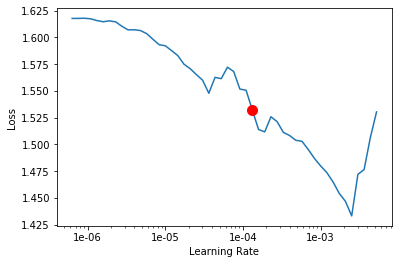

In [70]:
learner.recorder.plot(skip_end=10,suggestion=True)

We will pick a value a bit before the minimum, where the loss still improves. Here 1e-04 seems to be a good value.

Next we will use ``fit_one_cycle`` with the chosen learning rate as the maximum learning rate. 

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.569622,0.508335,0.817818,0.182182,40:48


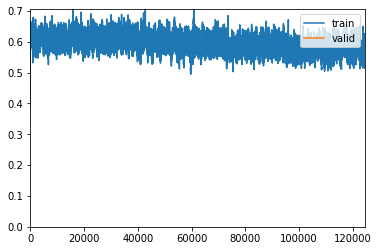

In [72]:
#learner.fit_one_cycle(1,max_lr=2e-03,moms=(0.8,0.7))
learner.fit_one_cycle(1,1e-04,moms=(0.8,0.7))

In [73]:
learner.save('pubmed_bert_multilanguage_first_cycle')

In [74]:
seed_all(seed)
learner.load('pubmed_bert_multilanguage_first_cycle');

We then unfreeze the second group of layers and repeat the operations.

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.383514,0.369980,0.865611,0.134389,46:09


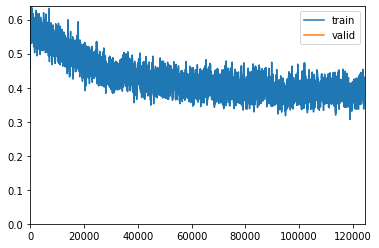

In [84]:
learner.freeze_to(-2)

lr = 1e-5
learner.fit_one_cycle(1, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))

In [85]:
learner.save('pubmed_bert_multilanguage_second_cycle')
seed_all(seed)
learner.load('pubmed_bert_multilanguage_second_cycle');

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.358130,0.348324,0.872614,0.127386,52:58


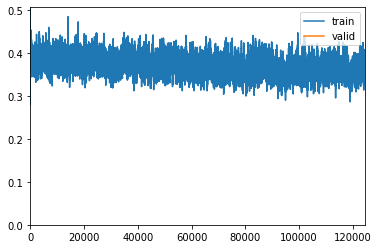

In [86]:
learner.freeze_to(-3)
learner.fit_one_cycle(1, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))

In [87]:
learner.save('pubmed_bert_multilanguage_third_cycle')
seed_all(seed)
learner.load('pubmed_bert_multilanguage_third_cycle');

## Export Learner
In order to export and load the learner you can do these operations:

In [90]:
learner.export(file = 'pubmed_rct_bert_multilang_transformer.pkl');

### Training all layers at once
If you want you can unfreeze all the layers. Be careful because this will demand more resources. 

In [ ]:
learner.unfreeze()
import torch
torch.cuda.empty_cache()

learner.fit_one_cycle(2, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))

# Inspect model performance

In [179]:
# get predictions  using validation dataset.

preds, targets = learner.get_preds(DatasetType.Valid) 
predictions = np.argmax(preds, axis = 1) 

Plot confusion matrix.

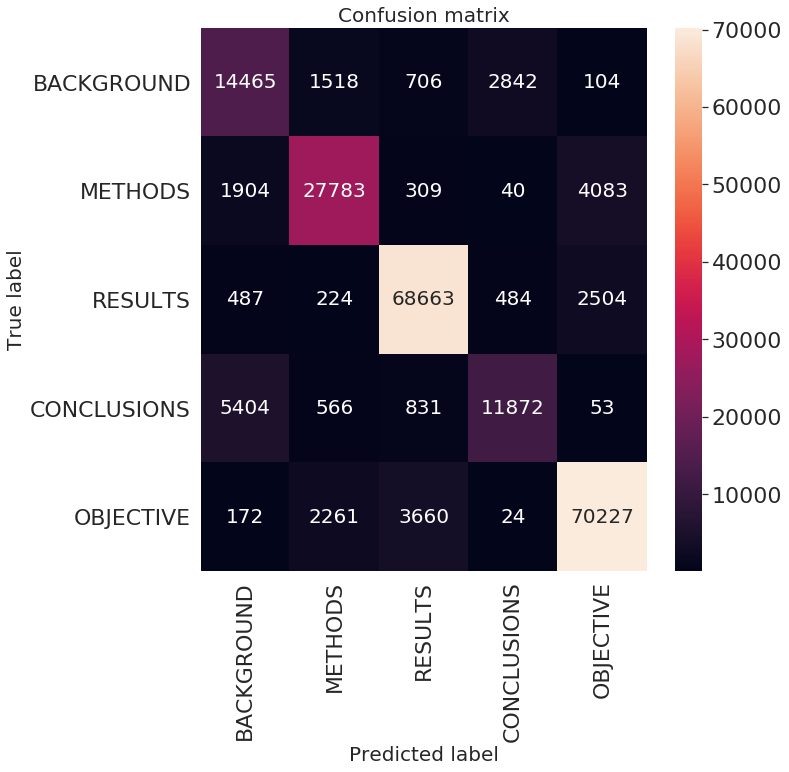

In [181]:
%matplotlib inline
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=2)

LABELS = categories

confusion_matrix = metrics.confusion_matrix(targets, predictions)

plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=20)
plt.ylabel('True label', fontsize=20)
plt.xlabel('Predicted label', fontsize=20)
plt.show()

# Time to try the model

The model is ready to infer the class for new sentences. 

In [91]:
# methods
learner.predict('A total of 192 MI patients and 140 control persons were included ')

(Category RESULTS,
 tensor(4),
 tensor([4.1968e-04, 1.3165e-03, 2.6977e-01, 3.0639e-04, 7.2818e-01]))

## Multi-language support

Since we trained using multi-language BERT, note that you can use different languages and the inference should be the same. 

In [93]:
# methods
learner.predict('Um total de 192 pacientes e 140 individuos controle foram incluidos ')

(Category RESULTS,
 tensor(4),
 tensor([3.4075e-04, 1.8489e-03, 2.4218e-01, 1.8800e-04, 7.5544e-01]))

In [94]:
#results
learner.predict('Condition effects were nonsignificant for social adjustment and substance use')

(Category RESULTS,
 tensor(4),
 tensor([1.7265e-04, 1.6399e-01, 2.6265e-03, 1.1106e-04, 8.3310e-01]))

In [100]:
#results
learner.predict('Os efeitos das condições não foram significativos para ajuste social e uso de substâncias')

(Category RESULTS, tensor(4), tensor([0.0033, 0.2943, 0.0051, 0.0013, 0.6961]))

In [96]:
# methods
learner.predict('The myocardial outcomes ( salvage index and final infarct size ) were measured by gated single-photon emission CT.')

(Category METHODS,
 tensor(2),
 tensor([6.0960e-04, 2.1637e-04, 6.7339e-01, 1.0028e-03, 3.2478e-01]))

In [97]:
# methods
learner.predict('Os desfechos do miocárdio (índice de salvamento e tamanho final do infarto) foram medidos por TC com emissão de fóton único.')

(Category METHODS,
 tensor(2),
 tensor([7.4887e-04, 1.0651e-03, 8.3441e-01, 7.8628e-04, 1.6299e-01]))

In [98]:
# backgrund
learner.predict("It was recently demonstrated that supraphysiological concentrations of the endogenous complement inhibitor MAp44 ( also denoted MAP1 ) protect against myocardial reperfusion injury")

(Category BACKGROUND,
 tensor(0),
 tensor([0.6905, 0.0034, 0.0015, 0.3032, 0.0014]))

## Inspect classification confidence on each class

In [150]:
#brackground
pred = learner.predict("Recentemente foi demonstrado que as concentrações suprafisiológicas do inibidor endógeno do complemento MAp44 (também denominado MAP1) protegem contra lesão de reperfusão do miocárdio")

(Category BACKGROUND,
 tensor(0),
 tensor([0.6535, 0.0257, 0.0048, 0.3108, 0.0053]))

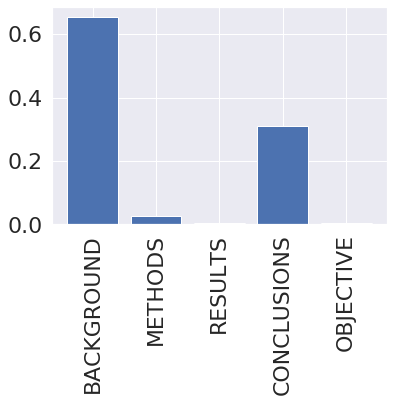

In [178]:

import matplotlib.pyplot as plt
plt.plot()

height = pred[2]
bars = categories
y_pos = np.arange(len(bars))
 
# Create bars
plt.bar(y_pos, height)
 
# Create names on the x-axis
plt.xticks(y_pos, bars, rotation='vertical')

# Show graphic
plt.show()

### Discussion

In this case in particular we observe that the model classifiers the sentence as *BACKGROUND*, but could also consider as *CONCLUSIONS*. One could argue that *background* sentences usually come in the begining of the text to contextualize the study and usually mentions conclusions from another previous studies. It would be expetected to confuse background as conclusions.  

# References
* Fastai with 🤗Transformers (BERT, RoBERTa, XLNet, XLM, DistilBERT) https://towardsdatascience.com/fastai-with-transformers-bert-roberta-xlnet-xlm-distilbert-4f41ee18ecb2
* Hugging Face, Transformers GitHub (Nov 2019), [https://github.com/huggingface/transformers](https://github.com/huggingface/transformers)
* Fast.ai, Fastai documentation (Nov 2019), [https://docs.fast.ai/text.html](https://docs.fast.ai/text.html)
* Jeremy Howard & Sebastian Ruder, Universal Language Model Fine-tuning for Text Classification (May 2018), [https://arxiv.org/abs/1801.06146](https://arxiv.org/abs/1801.06146)
* Keita Kurita's article : [A Tutorial to Fine-Tuning BERT with Fast AI](https://mlexplained.com/2019/05/13/a-tutorial-to-fine-tuning-bert-with-fast-ai/) (May 2019)
* Dev Sharma's article : [Using RoBERTa with Fastai for NLP](https://medium.com/analytics-vidhya/using-roberta-with-fastai-for-nlp-7ed3fed21f6c) (Sep 2019)

Arian Pasquali, April 2020